In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow as tf
%matplotlib inline
from tensorflow.keras.regularizers import L1L2

import fun1
import fun2
from sklearn.model_selection import train_test_split
import noniid2

2023-04-03 10:08:59.847336: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 10:08:59.850470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 10:08:59.850481: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def create_keras_model(tr_x):
    initializer = tf.keras.initializers.GlorotNormal()
    model = Sequential()
    model.add(Dense(20, activation = 'relu', 
                    input_shape=(tr_x.shape[1],), 
                    kernel_initializer=initializer))
    model.add(Dense(15, activation = 'relu', 
                    kernel_initializer=initializer))
    model.add(Dense(10, activation = 'relu', 
                    kernel_initializer=initializer))
    model.add(Dense(1, activation = 'sigmoid', 
                    kernel_initializer=initializer))
    return model   

In [3]:
def create_keras_model2(tr_x, regu_para):
    initializer = tf.keras.initializers.GlorotNormal()
    model = Sequential()
    model.add(Dense(20, activation = 'relu', 
                    input_shape=(tr_x.shape[1],), 
                    kernel_initializer=initializer, 
                    kernel_regularizer=L1L2(l1=regu_para,l2=regu_para)))
    model.add(Dense(15, activation = 'relu', 
                    kernel_initializer=initializer, 
                    kernel_regularizer=L1L2(l1=regu_para,l2=regu_para)))
    model.add(Dense(10, activation = 'relu', 
                    kernel_initializer=initializer, 
                    kernel_regularizer=L1L2(l1=regu_para,l2=regu_para)))
    model.add(Dense(1, activation = 'sigmoid', 
                    kernel_initializer=initializer, 
                    kernel_regularizer=L1L2(l1=regu_para,l2=regu_para)))
    return model   

In [4]:
def create_and_compile_model(tr_x, merge_w, lr, regu_para):
    
    model_m4 = create_keras_model2(tr_x, regu_para)
    model_m4.set_weights(merge_w)
    model_m4.compile(optimizer = optimizers.RMSprop(lr=lr, 
                                                    centered=True), 
                     loss = 'binary_crossentropy', 
                     metrics = ['accuracy'])
    return model_m4

In [5]:
from tensorflow.keras.callbacks import EarlyStopping
def model_train_round(
    model_m3, m3_tr_x, m3_tr_y, epo_num, bs):
    
    callback = EarlyStopping(monitor='loss', 
                             patience=epo_num, 
                             restore_best_weights=True)

    m3_h = model_m3.fit(m3_tr_x, m3_tr_y, 
                        batch_size = bs, epochs = epo_num, 
                        verbose = 0, callbacks=[callback])  
    return model_m3

In [6]:
import matplotlib.pyplot as plt
def plot_performance_curve(r_tr_acc_ls, 
                           total_rounds, tr_or_ts_acc):
    r_tr_acc_trans = np.array(r_tr_acc_ls).T
    rounds = range(1, total_rounds + 1)

    for line in r_tr_acc_trans:
        plt.plot(rounds, line, 'ko-')

    plt.xticks(np.arange(1, total_rounds+1, 1))    
    plt.xlabel('Round')
    plt.ylabel('{} Accuracy'.format(tr_or_ts_acc))
    plt.show()

In [7]:
def get_weight_ls(c0_tr_y_ls):
    cluster_size = []
    for i in c0_tr_y_ls:
        cluster_size.append(len(i))    
    total_size = sum(cluster_size)
    cluster_weight_ls = [x/total_size for x in cluster_size]
    return cluster_weight_ls

In [8]:
def non_iid_factors(m3tr, m4tr, etr):
    
    sig_p = 0.05
    df_cols = m3tr.columns.tolist()
    cat_com_elems = df_cols[4:6] 
    cont_com_elems = df_cols[6:]     

    cat_f_value_ls = []
    for cat_f in cat_com_elems:
        cat_f_value = m3tr[cat_f].unique()
        cat_f_value_ls.append(cat_f_value)    
    
    m3m4_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, m4tr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
    m3e_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, etr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
    m4e_noniid = noniid2.non_iid_degree(
        sig_p, m4tr, etr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
    
    m3_noniid_sum = sum([m3m4_noniid, m3e_noniid])
    m4_noniid_sum = sum([m3m4_noniid, m4e_noniid])
    e_noniid_sum = sum([m4e_noniid, m3e_noniid])
    
    total_noniid_sum = m3_noniid_sum+m4_noniid_sum+e_noniid_sum
    m3_factor = m3_noniid_sum/total_noniid_sum
    m4_factor = m4_noniid_sum/total_noniid_sum
    e_factor = e_noniid_sum/total_noniid_sum
    
    return m3_factor, m4_factor, e_factor

In [9]:
def non_iid_factors2(m3tr, m4tr, etr):
    
    sig_p = 0.05
    df_cols = m3tr.columns.tolist()
    cat_com_elems = df_cols[4:6] 
    cont_com_elems = df_cols[6:]     

    cat_f_value_ls = []
    for cat_f in cat_com_elems:
        cat_f_value = m3tr[cat_f].unique()
        cat_f_value_ls.append(cat_f_value)    
    
    m3m4_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, m4tr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
    m3e_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, etr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls)
#     m4e_noniid = noniid2.non_iid_degree(
#         sig_p, m4tr, etr, 
#         cont_com_elems, cat_com_elems, cat_f_value_ls)
    m3m3_noniid = noniid2.non_iid_degree(
        sig_p, m3tr, m3tr, 
        cont_com_elems, cat_com_elems, cat_f_value_ls) 
    
    total_noniid_sum = m3m3_noniid+m3m4_noniid+m3e_noniid
    m3_factor = m3m3_noniid/total_noniid_sum
    m4_factor = m3m4_noniid/total_noniid_sum
    e_factor = m3e_noniid/total_noniid_sum
    
    return m3_factor, m4_factor, e_factor

In [10]:
def data_preprocessing(m3tr, m3ts, m4tr, m4ts, 
                       etr, ets):
    df_cols = m3tr.columns.tolist()
    cat_f_ls = df_cols[4:6]
    for i in cat_f_ls:
        m3tr[i] = m3tr[i].astype('category').cat.codes
        m3ts[i] = m3ts[i].astype('category').cat.codes
        m4tr[i] = m4tr[i].astype('category').cat.codes 
        m4ts[i] = m4ts[i].astype('category').cat.codes
        etr[i] = etr[i].astype('category').cat.codes
        ets[i] = ets[i].astype('category').cat.codes 
    return m3tr, m3ts, m4tr, m4ts, etr, ets

In [11]:
validation_round = 5
epo_num = 10
bs = 50
total_rounds = 10
lr = 3e-3
lr_decay_rate = 0.95
model_types = 'nn'

In [12]:
path = '/home/ai03/_kunyi/pro_shae/datasets/aki_prediction_m4_m3_eicu/'
input_folder = '6tw_6ts_6pre_5 folds_v1_tr and ts/'
input_dir = path+input_folder

< Validation 1 >


2023-04-03 10:09:03.996573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-03 10:09:03.996651: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-04-03 10:09:03.996700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-04-03 10:09:03.998449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-04-03 10:09:03.998506: W tensorflow/stream_executor/platform/default/dso_loader

Round 1
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.99, m4 tr: 75.94, e tr: 84.33
m3 ts: 80.35, m4 ts: 75.35, e ts: 85.88
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.11, m4 tr: 76.17, e tr: 83.49
m3 ts: 80.78, m4 ts: 75.53, e ts: 86.19
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 80.86, m4 tr: 74.81, e tr: 85.75
m3 ts: 79.1, m4 ts: 74.21, e ts: 85.2
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 80.57, m4 tr: 75.0, e tr: 85.63
m3 ts: 79.51, m4 ts: 74.34, e ts: 85.36
Round 5
995/995 [==============================] - 1s 1ms/step
m3 tr: 78.09, m4 tr: 75.96, e tr: 84.4
m3 ts: 80.78, m4 ts: 75.22, e ts: 85.86
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 77.97, m4 tr: 75.92, e tr: 84.17
m3 ts: 80.72, m4 ts: 75.17, e ts: 85.87
Round 7
995/995 [==============================] - 2s 2ms/step
m3 tr: 77.31, m4 tr: 76.1, e tr: 83.8
m3 ts: 80.84, m4 ts: 75.34, e ts: 86.05
Round

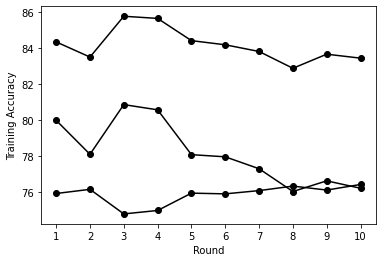

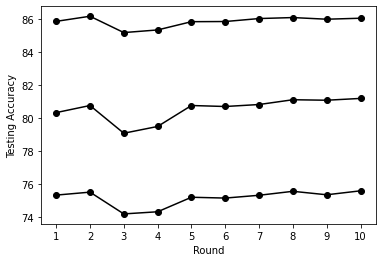

995/995 [==============================] - 2s 2ms/step
Validation 1 - Round m3 ts: 81.21, m4 ts: 75.61, e ts: 86.07
< Validation 2 >
Round 1
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.3, m4 tr: 71.97, e tr: 85.04
m3 ts: 76.0, m4 ts: 70.46, e ts: 84.82
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 80.7, m4 tr: 75.22, e tr: 85.06
m3 ts: 81.16, m4 ts: 72.64, e ts: 85.66
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.59, m4 tr: 75.35, e tr: 84.37
m3 ts: 81.54, m4 ts: 72.58, e ts: 85.34
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.23, m4 tr: 75.63, e tr: 83.36
m3 ts: 81.44, m4 ts: 72.66, e ts: 84.79
Round 5
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.71, m4 tr: 75.51, e tr: 84.04
m3 ts: 81.59, m4 ts: 72.55, e ts: 85.13
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 77.39, m4 tr: 75.9, e tr: 82.85
m3 ts: 81.36, m4 ts: 72.73, e ts: 84.33
Round 7
995/9

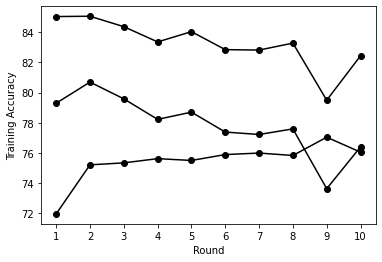

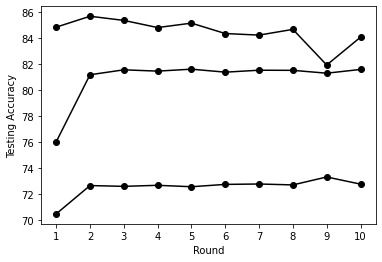

995/995 [==============================] - 2s 2ms/step
Validation 2 - Round m3 ts: 81.57, m4 ts: 72.75, e ts: 84.05
< Validation 3 >
Round 1
995/995 [==============================] - 1s 1ms/step
m3 tr: 78.62, m4 tr: 75.65, e tr: 82.61
m3 ts: 75.81, m4 ts: 73.8, e ts: 84.71
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.01, m4 tr: 74.8, e tr: 85.4
m3 ts: 74.75, m4 ts: 73.26, e ts: 86.03
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.07, m4 tr: 74.8, e tr: 85.65
m3 ts: 74.6, m4 ts: 73.13, e ts: 86.0
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.96, m4 tr: 75.37, e tr: 85.01
m3 ts: 75.16, m4 ts: 73.55, e ts: 85.74
Round 5
995/995 [==============================] - 1s 1ms/step
m3 tr: 78.86, m4 tr: 75.72, e tr: 84.41
m3 ts: 75.56, m4 ts: 73.72, e ts: 85.42
Round 6
995/995 [==============================] - 1s 1ms/step
m3 tr: 77.68, m4 tr: 76.03, e tr: 83.67
m3 ts: 75.81, m4 ts: 73.87, e ts: 84.86
Round 7
995/995

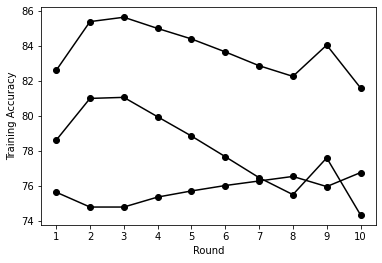

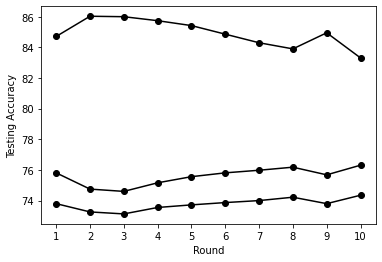

995/995 [==============================] - 2s 2ms/step
Validation 3 - Round m3 ts: 76.31, m4 ts: 74.35, e ts: 83.31
< Validation 4 >
Round 1
995/995 [==============================] - 2s 2ms/step
m3 tr: 62.56, m4 tr: 64.33, e tr: 76.43
m3 ts: 62.34, m4 ts: 64.99, e ts: 76.44
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.38, m4 tr: 76.5, e tr: 80.07
m3 ts: 79.66, m4 ts: 76.05, e ts: 85.94
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 80.68, m4 tr: 77.45, e tr: 74.67
m3 ts: 76.28, m4 ts: 76.94, e ts: 85.6
Round 4
995/995 [==============================] - 1s 1ms/step
m3 tr: 81.07, m4 tr: 76.92, e tr: 77.83
m3 ts: 77.84, m4 ts: 76.52, e ts: 85.78
Round 5
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.15, m4 tr: 76.78, e tr: 78.52
m3 ts: 77.96, m4 ts: 76.43, e ts: 85.8
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 80.84, m4 tr: 77.02, e tr: 76.69
m3 ts: 76.81, m4 ts: 76.46, e ts: 85.71
Round 7
995/

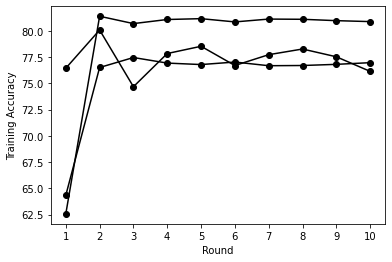

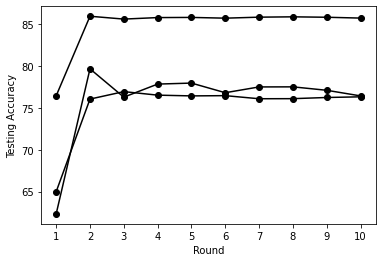

995/995 [==============================] - 2s 2ms/step
Validation 4 - Round m3 ts: 76.43, m4 ts: 76.32, e ts: 85.72
< Validation 5 >
Round 1
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.91, m4 tr: 72.21, e tr: 85.36
m3 ts: 72.19, m4 ts: 72.39, e ts: 84.33
Round 2
995/995 [==============================] - 2s 2ms/step
m3 tr: 81.96, m4 tr: 73.88, e tr: 85.89
m3 ts: 74.25, m4 ts: 74.2, e ts: 85.66
Round 3
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.64, m4 tr: 75.0, e tr: 84.28
m3 ts: 75.51, m4 ts: 75.66, e ts: 86.06
Round 4
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.62, m4 tr: 75.02, e tr: 83.66
m3 ts: 75.68, m4 ts: 75.55, e ts: 86.16
Round 5
995/995 [==============================] - 2s 2ms/step
m3 tr: 78.73, m4 tr: 74.97, e tr: 83.65
m3 ts: 75.75, m4 ts: 75.57, e ts: 86.11
Round 6
995/995 [==============================] - 2s 2ms/step
m3 tr: 79.01, m4 tr: 74.78, e tr: 83.95
m3 ts: 75.65, m4 ts: 75.45, e ts: 86.15
Round 7
995

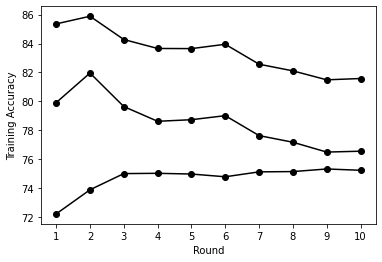

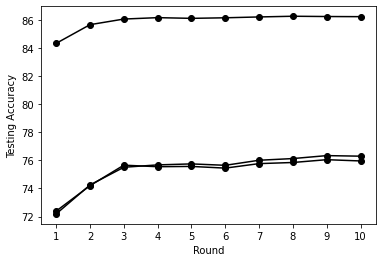

995/995 [==============================] - 2s 2ms/step
Validation 5 - Round m3 ts: 76.3, m4 ts: 75.96, e ts: 86.23


In [13]:
m3_acc_ls = []
m4_acc_ls = []
final_tr_acc_ls = []
final_ts_acc_ls = []
e_acc_little_data_ls = []
total_val_acc = []

for ri in range(1, validation_round+1):
    print('< Validation {} >'.format(ri))
    weighting_fac = 0.005
    
    m3tr = pd.read_csv(input_dir + "m3_tr_{}.csv".format(ri))
    m3ts = pd.read_csv(input_dir + "m3_ts_{}.csv".format(ri))   
    m4tr = pd.read_csv(input_dir + "m4_tr_{}.csv".format(ri))
    m4ts = pd.read_csv(input_dir + "m4_ts_{}.csv".format(ri))      
    etr = pd.read_csv(input_dir + "e_tr_{}.csv".format(ri))
    ets = pd.read_csv(input_dir + "e_ts_{}.csv".format(ri))  
    
    m3tr, m3ts, m4tr, m4ts, etr, ets = data_preprocessing(
        m3tr, m3ts, m4tr, m4ts, etr, ets)
    
    m3_factor, m4_factor, e_factor = non_iid_factors2(m3tr, m4tr, etr)
    noniid_ls = [m3_factor, m4_factor, e_factor]
    
    hos_tr_ls = [m3tr, m4tr, etr]
    hos_ts_ls = [m3ts, m4ts, ets]
    hos_tr_x_ls = []
    hos_tr_y_ls = []
    hos_ts_x_ls = []
    hos_ts_y_ls = []
    
    for hos_tr, hos_ts in zip(hos_tr_ls, hos_ts_ls):
        tr_x, tr_y = fun1.df_xy(hos_tr,5)
        ts_x, ts_y = fun1.df_xy(hos_ts,5)
        hos_tr_x_ls.append(tr_x)
        hos_tr_y_ls.append(tr_y)
        hos_ts_x_ls.append(ts_x)
        hos_ts_y_ls.append(ts_y)   
            
    cluster_weight_ls = get_weight_ls(hos_tr_y_ls)
    model_0 = create_keras_model(hos_tr_x_ls[0])
    merge_w = model_0.get_weights()
    r_tr_acc_ls = []
    r_ts_acc_ls = []

    for round_i in range(1, total_rounds+1):
        tr_acc_ls = []
        ts_acc_ls = []
        weighting_fac = weighting_fac * 0.9

        print('Round {}'.format(round_i))
        model_weight_ls = []

        for tr_x1, tr_y1, regu_para in zip(
            hos_tr_x_ls, hos_tr_y_ls, noniid_ls):
            
            m0 = create_and_compile_model(tr_x1, merge_w, 
                                          lr, regu_para*weighting_fac)
            m1 = model_train_round(m0, tr_x1, tr_y1, 
                                   epo_num, bs)
            m1_w = m1.get_weights()
            model_weight_ls.append(m1_w)
            
#         merge_w = np.average(model_weight_ls, axis=0, 
#                              weights=cluster_weight_ls)
        merge_w = np.average(model_weight_ls, axis=0)
        m2 = create_keras_model(hos_tr_x_ls[0])
        m2.set_weights(merge_w)    
        lr = lr*lr_decay_rate

        for tr_x, tr_y, ts_x, ts_y in zip(
            hos_tr_x_ls, hos_tr_y_ls, hos_ts_x_ls, hos_ts_y_ls):

            tr_acc = fun2.evaulate_acc(m2, tr_x, tr_y)
            ts_acc = fun2.evaulate_acc(m2, ts_x, ts_y)
            tr_acc_ls.append(tr_acc)
            ts_acc_ls.append(ts_acc)

        print('m3 tr: {}, m4 tr: {}, e tr: {}'.format(
            tr_acc_ls[0], tr_acc_ls[1], tr_acc_ls[2]))
        print('m3 ts: {}, m4 ts: {}, e ts: {}'.format(
            ts_acc_ls[0], ts_acc_ls[1], ts_acc_ls[2]))
        
        r_tr_acc_ls.append(tr_acc_ls)
        r_ts_acc_ls.append(ts_acc_ls)   

    avg_tr = np.mean(r_tr_acc_ls)
    avg_ts = np.mean(r_ts_acc_ls)
    print('tr acc:', avg_tr)
    print('ts acc:', avg_ts)

    plot_performance_curve(r_tr_acc_ls, total_rounds, 'Training')
    plot_performance_curve(r_ts_acc_ls, total_rounds, 'Testing')
    
    val_ts_ls = []
    for ts_x, ts_y in zip(hos_ts_x_ls, hos_ts_y_ls):
        ts_acc = fun2.evaulate_acc(m2, ts_x, ts_y)
        val_ts_ls.append(ts_acc)
        
    print('Validation {} - Round m3 ts: {}, m4 ts: {}, e ts: {}'.format(
        ri, val_ts_ls[0], val_ts_ls[1], val_ts_ls[2]))    
    total_val_acc.append(val_ts_ls)

In [14]:
total_val_acc

[[81.21, 75.61, 86.07],
 [81.57, 72.75, 84.05],
 [76.31, 74.35, 83.31],
 [76.43, 76.32, 85.72],
 [76.3, 75.96, 86.23]]

In [15]:
import statistics

acc_ls = []
total_val_acc_t = np.array(total_val_acc).T.tolist()
for each_acc in total_val_acc_t:
    m_acc = statistics.mean(each_acc)
    print(m_acc)
    acc_ls.append(m_acc)
print('mean: ',statistics.mean(acc_ls))

78.364
74.99799999999999
85.076
mean:  79.47933333333333
